# Data Assessment

In [2]:
import os
import sys
from pathlib import Path

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
sys.path.insert(0, '../lib')
from ncbi_remap.notebook import Nb
from ncbi_remap.plotting import make_figs

In [3]:
# Setup notebook
nbconfig = Nb.setup_notebook()

# Connect to data store
store = pd.HDFStore('../output/sra.h5', mode='r')

Please check output/fbgn2chrom.tsv. If it does not exist, run bin/fbgn2chrom.py
last updated: 2018-08-15 
Git hash: 3e6018d790e56d8ccd70647a7eccff8c120a8e6d


In [82]:
from pymongo import MongoClient
try:
    with open('../output/.mongodb_host', 'r') as fh:
        host = fh.read().strip()
except FileNotFoundError:
    host = 'localhost'

mongoClient = MongoClient(host=host, port=27017)
db = mongoClient['sra']
ncbi = db['ncbi']

In [171]:
# Get the dates samples were loaded
load_date = pd.DataFrame(list(ncbi.aggregate([
    {
        '$unwind': {
            'path': '$runs'
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$srx',
            'srr': '$runs.srr',
            'load_date': '$runs.load_date'
        }
    },
])))

load_date['load_date'] = pd.to_datetime(load_date.load_date)
load_date.dropna(inplace=True)
load_date.set_index(['srx', 'srr'], inplace=True)

### How many samples have completed the workflow?

In [8]:
srx_cnt = store['aln/complete'].srx.unique().shape[0]
srr_cnt = store['aln/complete'].srr.unique().shape[0]
print(f'There are {srx_cnt:,} SRXs and {srr_cnt:,} SRRs.')

There are 27,141 SRXs and 34,058 SRRs.


In [258]:
srr_complete = store['aln/complete'].srr.unique()
srx_complete = store['aln/complete'].srx.unique()
layout = store.select('layout', where='srr == srr_complete')
libsize = store.select('prealn/workflow/fastq', where='srr == srr_complete')
libsize_layout = libsize.join(layout)

In [259]:
pe = libsize_layout.query('layout == "PE"').libsize_R1
pe.name = 'libsize'

se = libsize_layout.query('layout == "SE" or layout == "keep_R1"').libsize_R1
se.name = 'libsize'

r2 = libsize_layout.query('layout == "keep_R2"').libsize_R2
r2.name = 'libsize'

se = pd.concat([se, r2])

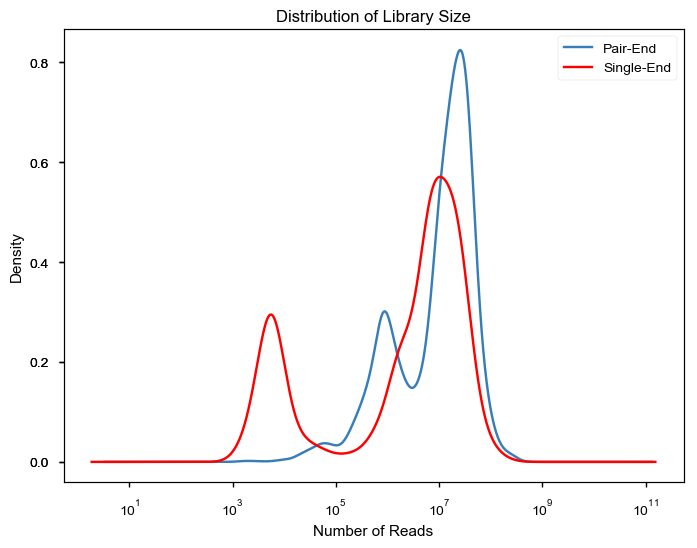

In [260]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax2 = ax.twiny()

np.log10(pe).plot.kde(ax=ax2, label='Pair-End')
np.log10(se).plot.kde(ax=ax2, c='r', label='Single-End')

# using the twin axis trick to make nice looking log axis
ax.set_xlim(10**np.array(ax2.get_xlim()))
ax2.set_xticklabels([])
ax2.set_xticks([])

ax.set_title('Distribution of Library Size')
ax.set_xlabel('Number of Reads')
plt.legend();

In [261]:
libsize = pd.concat([pe, se])
libsize.describe()[['min', 'mean', 'max']].apply(lambda x: f'{x:,.0f}')

min           1,003
mean     13,922,455
max     297,351,765
Name: libsize, dtype: object

### What about read length with time?

In [262]:
read_len = store.select('prealn/workflow/fastq', where='srr == srr_complete', columns=['avgLen_R1', 'avgLen_R2'])
read_len = read_len.max(axis=1)
read_len.name = 'read_len'
read_len = read_len[read_len < 400]

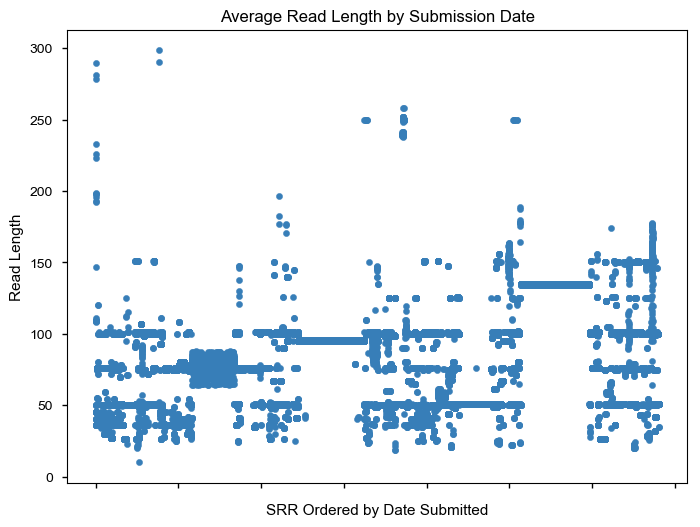

In [263]:
read_len_by_date = read_len.to_frame().join(load_date).sort_values('load_date')

ax = read_len_by_date.assign(sample_order = range(1, read_len_by_date.shape[0] + 1)).plot.scatter('sample_order', 'read_len')
ax.set_title('Average Read Length by Submission Date')
ax.set_xlabel('SRR Ordered by Date Submitted')
ax.set_ylabel('Read Length');
ax.set_xticklabels([]);

### Is libsize correlated with load date?

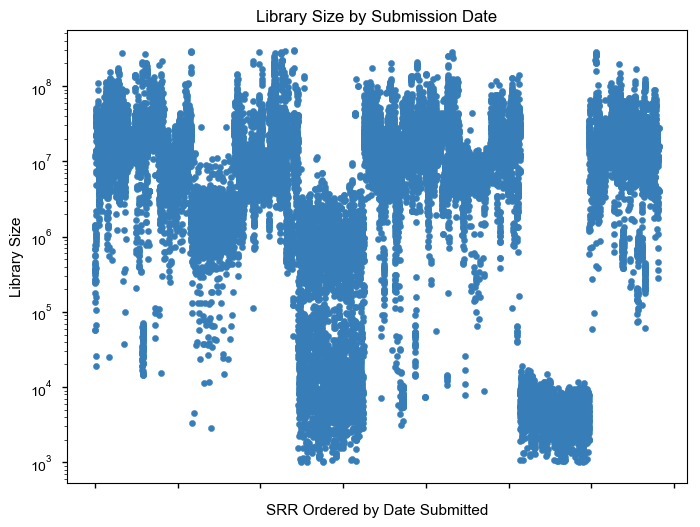

In [264]:
libsize_by_date = libsize.to_frame().join(load_date).sort_values('load_date')

ax = libsize_by_date.assign(sample_order = range(1, libsize_by_date.shape[0] + 1)).plot.scatter('sample_order', 'libsize')
ax.set_yscale('log')
ax.set_title('Library Size by Submission Date')
ax.set_xlabel('SRR Ordered by Date Submitted')
ax.set_ylabel('Library Size');
ax.set_xticklabels([]);

### What does percent mapability look like?

Note: I am using the final alignments from the aln-workflow.

In [265]:
_map = store.select('aln/workflow/hisat2', where='srr == srr_complete', columns=['per_alignment']).iloc[:, 0]

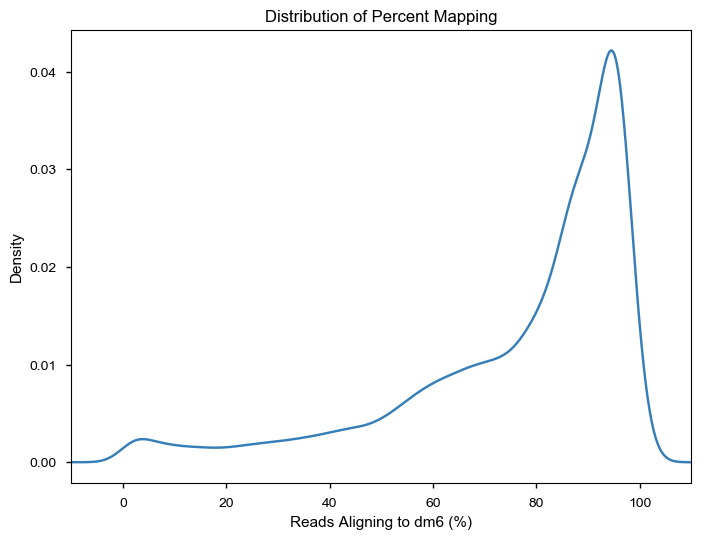

In [266]:
fig, ax = plt.subplots()
_map.plot.kde()

ax.set_title('Distribution of Percent Mapping')
ax.set_xlabel('Reads Aligning to dm6 (%)')
ax.set_xlim(-10, 110);

In [267]:
_map.describe()[['min', 'mean', 'max']]

min      0.510000
mean    77.172522
max     99.990000
Name: per_alignment, dtype: float64

In [268]:
gt80 = (_map >= 80).sum()
pct_gt80 = gt80 / _map.shape[0] * 100
print(f'Around {pct_gt80:,.0f}% of SRRs (n = {gt80:,}) had more than 80% of reads mapping.')

Around 61% of SRRs (n = 20,671) had more than 80% of reads mapping.


### Is mapability associated with date the sample was loaded?

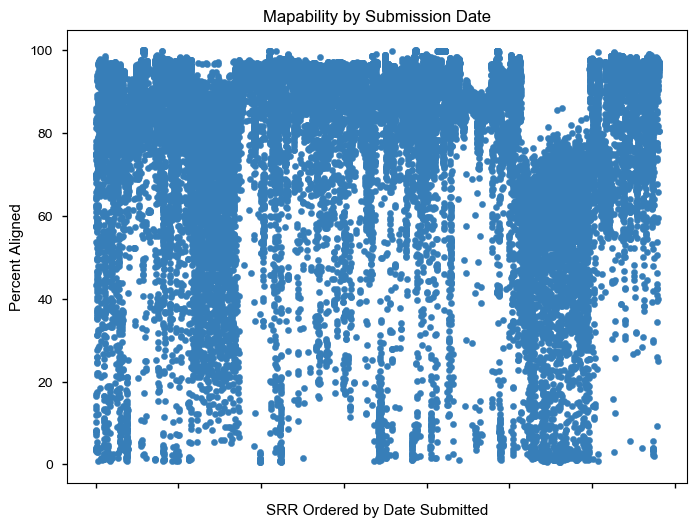

In [269]:
map_by_date = _map.to_frame().join(load_date).sort_values('load_date')

ax = map_by_date.assign(sample_order = range(1, map_by_date.shape[0] + 1)).plot.scatter('sample_order', 'per_alignment')
ax.set_title('Mapability by Submission Date')
ax.set_xlabel('SRR Ordered by Date Submitted')
ax.set_ylabel('Percent Aligned');
ax.set_xticklabels([]);

### What does the chromosomal distribution look like?

Note: I am ignoring all of the scaffolds, so percentages are not exact. However, the fraction mapping to these scaffolds is so small I don't think it is worth the complexity to explain.

In [271]:
# Munge data to pull out only major chromosomes arms and mito.
def parse_idxstats(srx):
    keep = ['chrX', 'chr2L', 'chr2R', 'chr3L', 'chr3R', 'chrY', 'chrM']
    df = pd.read_parquet(f'../output/aln-wf/samtools_idxstats/{srx}.parquet', columns=['chrom', '# mapped reads']).query(f'chrom == {keep}')
    df.columns = [srx]
    return df.T[keep]

dfs = []
for srx in srx_complete:
    try:
        dfs.append(parse_idxstats(srx))
    except FileNotFoundError:
        pass

idxstats = pd.concat(dfs)

In [315]:
# grab the number of mapped reads.
num_reads = store['aln/workflow/samtools_stats'].reads_mapped
num_reads.name = 'num_reads'
num_reads = num_reads.reindex(idxstats.index)

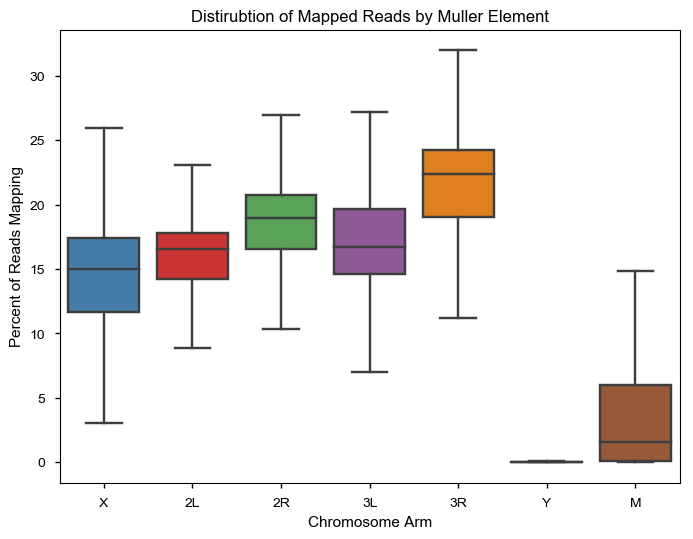

In [353]:
ax = sns.boxplot('chrom', 'value', data=(idxstats.div(num_reads, axis='rows') * 100).melt(),
            showfliers=False,
            order=['chrX', 'chr2L', 'chr2R', 'chr3L', 'chr3R', 'chrY', 'chrM']
           )
ax.set_xlabel('Chromosome Arm')
ax.set_ylabel('Percent of Reads Mapping')
ax.set_title('Distirubtion of Mapped Reads by Muller Element')

new = []
for l in ax.get_xticklabels():
    new.append(l.get_text().strip('chr'))
ax.set_xticklabels(new);

In [356]:
pct_map_muller = idxstats.iloc[:, :-1].sum(axis=1) / num_reads * 100
print('Percent reads aligning to a muller element {:.2f}%'.format(pct_map_muller.describe()['mean']))

Percent reads aligning to a muller element 92.45%


In [357]:
print("Percent of reads mapping to major chroms")
idxstats.sum() / idxstats.sum().sum() * 100

Percent of reads mapping to major chroms


chrom
chrX     15.659458
chr2L    17.322080
chr2R    19.502066
chr3L    18.609380
chr3R    23.071689
chrY      0.092187
chrM      5.743140
dtype: float64